In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries loaded successfully")
print("📊 Starting Price Anchoring Analysis on Amazon India Data")

✅ Libraries loaded successfully
📊 Starting Price Anchoring Analysis on Amazon India Data


In [3]:
# Load the three datasets
amazon_sales = pd.read_csv(r'../DataSets/Amazon Sale Report.csv')
pricing_may2022 = pd.read_csv(r'../DataSets/May-2022.csv')
pricing_mar2021 = pd.read_csv(r'../DataSets/P  L March 2021.csv')

print("=== DATASET SHAPES ===")
print(f"Amazon Sales Report: {amazon_sales.shape}")
print(f"May 2022 Pricing: {pricing_may2022.shape}")
print(f"March 2021 Pricing: {pricing_mar2021.shape}")

print("\n=== AMAZON SALES COLUMNS ===")
print(list(amazon_sales.columns))

print("\n=== MAY 2022 PRICING COLUMNS ===")
print(list(pricing_may2022.columns))

print("\n=== MARCH 2021 PRICING COLUMNS ===")
print(list(pricing_mar2021.columns))

=== DATASET SHAPES ===
Amazon Sales Report: (128975, 24)
May 2022 Pricing: (1330, 17)
March 2021 Pricing: (1330, 18)

=== AMAZON SALES COLUMNS ===
['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22']

=== MAY 2022 PRICING COLUMNS ===
['index', 'Sku', 'Style Id', 'Catalog', 'Category', 'Weight', 'TP', 'MRP Old', 'Final MRP Old', 'Ajio MRP', 'Amazon MRP', 'Amazon FBA MRP', 'Flipkart MRP', 'Limeroad MRP', 'Myntra MRP', 'Paytm MRP', 'Snapdeal MRP']

=== MARCH 2021 PRICING COLUMNS ===
['index', 'Sku', 'Style Id', 'Catalog', 'Category', 'Weight', 'TP 1', 'TP 2', 'MRP Old', 'Final MRP Old', 'Ajio MRP', 'Amazon MRP', 'Amazon FBA MRP', 'Flipkart MRP', 'Limeroad MRP', 'Myntra MRP', 'Paytm MRP', 'Snapdeal MRP']


In [4]:
# Examine Amazon sales data structure
print("=== AMAZON SALES DATA OVERVIEW ===")
print(amazon_sales.info())

print("\n=== FIRST 5 ROWS ===")
print(amazon_sales.head())

print("\n=== UNIQUE VALUES IN KEY COLUMNS ===")
print("Status values:", amazon_sales['Status'].value_counts())
print("\nFulfilment values:", amazon_sales['Fulfilment'].value_counts())

print("\n=== MISSING VALUES ===")
print(amazon_sales.isnull().sum())

print("\n=== BASIC STATISTICS ===")
print(amazon_sales.describe())

=== AMAZON SALES DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15 

In [5]:
# Examine May 2022 pricing data (main reference)
print("=== MAY 2022 PRICING DATA OVERVIEW ===")
print(pricing_may2022.info())

print("\n=== FIRST 5 ROWS ===")
print(pricing_may2022.head())

print("\n=== MISSING VALUES ===")
print(pricing_may2022.isnull().sum())

print("\n=== KEY PRICING COLUMNS STATISTICS ===")
pricing_cols = ['Amazon MRP', 'Ajio MRP', 'Flipkart MRP', 'TP']
for col in pricing_cols:
    if col in pricing_may2022.columns:
        print(f"\n{col}:")
        print(pricing_may2022[col].describe())

=== MAY 2022 PRICING DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           1330 non-null   int64 
 1   Sku             1330 non-null   object
 2   Style Id        1330 non-null   object
 3   Catalog         1330 non-null   object
 4   Category        1330 non-null   object
 5   Weight          1330 non-null   object
 6   TP              1330 non-null   object
 7   MRP Old         1330 non-null   object
 8   Final MRP Old   1330 non-null   object
 9   Ajio MRP        1330 non-null   object
 10  Amazon MRP      1330 non-null   object
 11  Amazon FBA MRP  1330 non-null   object
 12  Flipkart MRP    1330 non-null   object
 13  Limeroad MRP    1330 non-null   object
 14  Myntra MRP      1330 non-null   object
 15  Paytm MRP       1330 non-null   object
 16  Snapdeal MRP    1330 non-null   object
dtypes: int64(1), 

In [6]:
# Clean Amazon sales data
print("=== CLEANING AMAZON SALES DATA ===")

# Convert Date column to datetime
amazon_sales['Date'] = pd.to_datetime(amazon_sales['Date'], errors='coerce')

# Convert Amount to numeric (remove currency symbols if any)
amazon_sales['Amount'] = pd.to_numeric(amazon_sales['Amount'].astype(str).str.replace('[₹,]', '', regex=True), errors='coerce')

# Convert Qty to numeric
amazon_sales['Qty'] = pd.to_numeric(amazon_sales['Qty'], errors='coerce')

# Filter for valid/successful orders (shipped or delivered)
valid_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Delivered to Buyer']
amazon_sales_clean = amazon_sales[amazon_sales['Status'].isin(valid_statuses)].copy()

print(f"Original orders: {len(amazon_sales)}")
print(f"Valid/successful orders: {len(amazon_sales_clean)}")
print(f"Filtered out: {len(amazon_sales) - len(amazon_sales_clean)} orders")

print("\n=== POST-CLEANING STATISTICS ===")
print(f"Date range: {amazon_sales_clean['Date'].min()} to {amazon_sales_clean['Date'].max()}")
print(f"Amount range: ₹{amazon_sales_clean['Amount'].min():.2f} to ₹{amazon_sales_clean['Amount'].max():.2f}")
print(f"Quantity range: {amazon_sales_clean['Qty'].min()} to {amazon_sales_clean['Qty'].max()}")

=== CLEANING AMAZON SALES DATA ===
Original orders: 128975
Valid/successful orders: 106573
Filtered out: 22402 orders

=== POST-CLEANING STATISTICS ===
Date range: 2022-03-31 00:00:00 to 2022-06-29 00:00:00
Amount range: ₹0.00 to ₹5584.00
Quantity range: 0 to 15


In [7]:
# Clean pricing data
print("=== CLEANING PRICING DATA ===")

# Clean Amazon MRP column in May 2022 data
if 'Amazon MRP' in pricing_may2022.columns:
    pricing_may2022['Amazon MRP'] = pd.to_numeric(
        pricing_may2022['Amazon MRP'].astype(str).str.replace('[₹,]', '', regex=True), 
        errors='coerce'
    )

# Check for duplicate SKUs in pricing data
print(f"Total SKUs in pricing data: {len(pricing_may2022)}")
print(f"Unique SKUs in pricing data: {pricing_may2022['Sku'].nunique()}")

# Remove rows with missing Amazon MRP (crucial for our analysis)
pricing_clean = pricing_may2022.dropna(subset=['Amazon MRP']).copy()
print(f"SKUs with valid Amazon MRP: {len(pricing_clean)}")

print("\n=== AMAZON MRP STATISTICS ===")
print(pricing_clean['Amazon MRP'].describe())

=== CLEANING PRICING DATA ===
Total SKUs in pricing data: 1330
Unique SKUs in pricing data: 1330
SKUs with valid Amazon MRP: 1293

=== AMAZON MRP STATISTICS ===
count    1293.000000
mean     2247.789211
std       704.073990
min       199.000000
25%      1795.000000
50%      2097.000000
75%      2495.000000
max      5997.000000
Name: Amazon MRP, dtype: float64


In [8]:
# Merge sales data with pricing data
print("=== MERGING SALES AND PRICING DATA ===")

# First, let's see overlap between datasets
sales_skus = set(amazon_sales_clean['SKU'].unique())
pricing_skus = set(pricing_clean['Sku'].unique())

print(f"Unique SKUs in sales data: {len(sales_skus)}")
print(f"Unique SKUs in pricing data: {len(pricing_skus)}")
print(f"SKUs in both datasets: {len(sales_skus.intersection(pricing_skus))}")

# Merge datasets
merged_data = amazon_sales_clean.merge(
    pricing_clean[['Sku', 'Amazon MRP', 'Category']], 
    left_on='SKU', 
    right_on='Sku', 
    how='inner'
)

print(f"\nSuccessfully merged records: {len(merged_data)}")
print(f"Unique SKUs in merged data: {merged_data['SKU'].nunique()}")

# Calculate discount metrics
merged_data['Discount_Amount'] = merged_data['Amazon MRP'] - merged_data['Amount']
merged_data['Discount_Percentage'] = (merged_data['Discount_Amount'] / merged_data['Amazon MRP']) * 100

print("\n=== DISCOUNT METRICS OVERVIEW ===")
print(merged_data[['Amazon MRP', 'Amount', 'Discount_Amount', 'Discount_Percentage']].describe())

=== MERGING SALES AND PRICING DATA ===
Unique SKUs in sales data: 7079
Unique SKUs in pricing data: 1293
SKUs in both datasets: 0

Successfully merged records: 0
Unique SKUs in merged data: 0

=== DISCOUNT METRICS OVERVIEW ===
       Amazon MRP  Amount  Discount_Amount  Discount_Percentage
count         0.0     0.0              0.0                  0.0
mean          NaN     NaN              NaN                  NaN
std           NaN     NaN              NaN                  NaN
min           NaN     NaN              NaN                  NaN
25%           NaN     NaN              NaN                  NaN
50%           NaN     NaN              NaN                  NaN
75%           NaN     NaN              NaN                  NaN
max           NaN     NaN              NaN                  NaN


In [9]:
# Diagnose the SKU mismatch issue
print("=== DIAGNOSING SKU MISMATCH ===")

# Sample SKUs from each dataset
print("Sample SKUs from Amazon Sales:")
print(amazon_sales_clean['SKU'].head(10).tolist())

print("\nSample SKUs from Pricing Data:")
print(pricing_clean['Sku'].head(10).tolist())

# Check SKU formats
print("\nSKU Format Analysis:")
print("Sales SKU patterns:")
sales_sku_samples = amazon_sales_clean['SKU'].head(20)
for sku in sales_sku_samples:
    print(f"  {sku} (length: {len(sku)})")

print("\nPricing SKU patterns:")
pricing_sku_samples = pricing_clean['Sku'].head(20)
for sku in pricing_sku_samples:
    print(f"  {sku} (length: {len(sku)})")

# Check if there's a pattern in Style column that might match
print("\nStyle Column Analysis:")
print("Sample Styles from Sales:", amazon_sales_clean['Style'].head(10).tolist())
print("Sample Style IDs from Pricing:", pricing_clean['Style Id'].head(10).tolist())



# Try alternative matching strategies
print("=== EXPLORING ALTERNATIVE MATCHING ===")

# Check if Style can be used as a bridge
sales_styles = set(amazon_sales_clean['Style'].unique())
pricing_styles = set(pricing_clean['Style Id'].unique())

print(f"Unique Styles in sales data: {len(sales_styles)}")
print(f"Unique Style IDs in pricing data: {len(pricing_styles)}")
print(f"Styles in both datasets: {len(sales_styles.intersection(pricing_styles))}")

if len(sales_styles.intersection(pricing_styles)) > 0:
    print("✅ We can match using Style/Style ID!")
    
    # Merge using Style instead of SKU
    merged_data = amazon_sales_clean.merge(
        pricing_clean[['Style Id', 'Amazon MRP', 'Category']], 
        left_on='Style', 
        right_on='Style Id', 
        how='inner'
    )
    
    print(f"Successfully merged records using Style: {len(merged_data)}")
    print(f"Unique Styles in merged data: {merged_data['Style'].nunique()}")
    
else:
    print("❌ Style matching also failed. Checking partial matches...")
    
    # Check for partial string matches
    sample_sales_skus = list(amazon_sales_clean['SKU'].head(100))
    sample_pricing_skus = list(pricing_clean['Sku'].head(100))
    
    print("Looking for partial matches...")
    partial_matches = 0
    for s_sku in sample_sales_skus[:20]:
        for p_sku in sample_pricing_skus:
            if any(part in p_sku for part in s_sku.split('-') if len(part) > 3):
                print(f"Potential match: {s_sku} <-> {p_sku}")
                partial_matches += 1
                break
    
    print(f"Found {partial_matches} potential partial matches")

# If no direct matching is possible, analyze what we CAN do with the data
print("=== ALTERNATIVE ANALYSIS STRATEGY ===")

if 'merged_data' in locals() and len(merged_data) > 0:
    print("✅ Using Style-based matching for analysis")
    # Calculate discount metrics
    merged_data['Discount_Amount'] = merged_data['Amazon MRP'] - merged_data['Amount']
    merged_data['Discount_Percentage'] = (merged_data['Discount_Amount'] / merged_data['Amazon MRP']) * 100
    
    print("=== DISCOUNT METRICS OVERVIEW ===")
    print(merged_data[['Amazon MRP', 'Amount', 'Discount_Amount', 'Discount_Percentage']].describe())
    
else:
    print("❌ No direct matching possible. Proceeding with analysis of available data patterns...")
    
    # Analyze sales data independently
    print("=== SALES DATA ANALYSIS (WITHOUT PRICING) ===")
    
    # Group by SKU for sales analysis
    sales_aggregated = amazon_sales_clean.groupby('SKU').agg({
        'Qty': 'sum',
        'Amount': ['mean', 'count'],
        'Category': 'first'
    }).round(2)
    
    sales_aggregated.columns = ['Total_Qty', 'Avg_Amount', 'Order_Count', 'Category']
    
    print(f"Analyzed {len(sales_aggregated)} unique SKUs")
    print(sales_aggregated.describe())
    
    # Analyze pricing data independently  
    print("\n=== PRICING DATA ANALYSIS (STANDALONE) ===")
    print("Amazon MRP distribution across categories:")
    pricing_by_category = pricing_clean.groupby('Category')['Amazon MRP'].agg(['count', 'mean', 'std']).round(2)
    print(pricing_by_category.head(10))
    
    # Create synthetic discount analysis using sales amount distribution
    print("\n=== CREATING PRICE TIER ANALYSIS ===")
    
    # Analyze sales by price tiers (using actual selling amounts)
    sales_aggregated['Price_Tier'] = pd.cut(
        sales_aggregated['Avg_Amount'], 
        bins=[0, 300, 500, 800, 1200, 6000], 
        labels=['Budget(<300)', 'Low(300-500)', 'Mid(500-800)', 'High(800-1200)', 'Premium(1200+)']
    )
    
    tier_analysis = sales_aggregated.groupby('Price_Tier').agg({
        'Total_Qty': ['count', 'mean', 'sum'],
        'Avg_Amount': 'mean'
    }).round(2)
    
    print("Sales performance by price tiers:")
    print(tier_analysis)

=== DIAGNOSING SKU MISMATCH ===
Sample SKUs from Amazon Sales:
['JNE3781-KR-XXXL', 'JNE3371-KR-XL', 'JNE3671-TU-XXXL', 'SET264-KR-NP-XL', 'J0095-SET-L', 'JNE3405-KR-S', 'JNE3461-KR-XXL', 'JNE3160-KR-G-S', 'JNE3500-KR-XS', 'JNE3405-KR-XS']

Sample SKUs from Pricing Data:
['Os206_3141_S', 'Os206_3141_M', 'Os206_3141_L', 'Os206_3141_XL', 'Os206_3141_2XL', 'Os206_3141_3XL', 'Os223_3142_S', 'Os223_3142_M', 'Os223_3142_L', 'Os223_3142_XL']

SKU Format Analysis:
Sales SKU patterns:
  JNE3781-KR-XXXL (length: 15)
  JNE3371-KR-XL (length: 13)
  JNE3671-TU-XXXL (length: 15)
  SET264-KR-NP-XL (length: 15)
  J0095-SET-L (length: 11)
  JNE3405-KR-S (length: 12)
  JNE3461-KR-XXL (length: 14)
  JNE3160-KR-G-S (length: 14)
  JNE3500-KR-XS (length: 13)
  JNE3405-KR-XS (length: 13)
  SET182-KR-DH-XS (length: 15)
  J0351-SET-L (length: 11)
  PJNE3368-KR-6XL (length: 15)
  JNE3721-KR-XXL (length: 14)
  JNE3405-KR-XL (length: 13)
  JNE3697-KR-XXL (length: 14)
  SET254-KR-NP-XS (length: 15)
  JNE3795-KR-XXX

In [10]:
# Since we can't match exact pricing, let's analyze price anchoring through price tiers
print("=== MODIFIED PRICE ANCHORING ANALYSIS ===")
print("Strategy: Analyze sales patterns across different price points")

# Enhanced price tier analysis
sales_aggregated['Price_Tier_Detailed'] = pd.cut(
    sales_aggregated['Avg_Amount'], 
    bins=[0, 250, 350, 450, 550, 700, 900, 1200, 6000], 
    labels=['<250', '250-350', '350-450', '450-550', '550-700', '700-900', '900-1200', '1200+']
)

# Comprehensive tier analysis
tier_detailed = sales_aggregated.groupby('Price_Tier_Detailed').agg({
    'Total_Qty': ['count', 'mean', 'sum', 'std'],
    'Avg_Amount': ['mean', 'std'],
    'Order_Count': ['mean', 'sum']
}).round(2)

tier_detailed.columns = ['SKU_Count', 'Avg_Qty_per_SKU', 'Total_Qty_Sold', 'Qty_Std', 
                        'Avg_Price', 'Price_Std', 'Avg_Orders_per_SKU', 'Total_Orders']

print("=== DETAILED PRICE TIER ANALYSIS ===")
print(tier_detailed)

# Calculate performance metrics
tier_detailed['Qty_per_SKU_per_Price'] = tier_detailed['Avg_Qty_per_SKU'] / tier_detailed['Avg_Price'] * 1000
tier_detailed['Revenue_per_SKU'] = tier_detailed['Avg_Qty_per_SKU'] * tier_detailed['Avg_Price']

print("\n=== PERFORMANCE METRICS BY PRICE TIER ===")
print(tier_detailed[['Avg_Qty_per_SKU', 'Qty_per_SKU_per_Price', 'Revenue_per_SKU']].round(2))

=== MODIFIED PRICE ANCHORING ANALYSIS ===
Strategy: Analyze sales patterns across different price points
=== DETAILED PRICE TIER ANALYSIS ===
                     SKU_Count  Avg_Qty_per_SKU  Total_Qty_Sold  Qty_Std  \
Price_Tier_Detailed                                                        
<250                        63             2.38             150     1.47   
250-350                   1028             7.47            7681    12.52   
350-450                   1125            17.25           19408    35.02   
450-550                   1322            12.55           16595    19.32   
550-700                   1480            15.88           23502    26.53   
700-900                   1105            21.24           23473    46.15   
900-1200                   671            18.98           12738    31.45   
1200+                      256            12.95            3315    15.48   

                     Avg_Price  Price_Std  Avg_Orders_per_SKU  Total_Orders  
Price_Tier_Detailed

In [11]:
# Analyze sales patterns by category
print("=== CATEGORY-BASED SALES ANALYSIS ===")

category_analysis = sales_aggregated.groupby('Category').agg({
    'Total_Qty': ['count', 'mean', 'sum'],
    'Avg_Amount': ['mean', 'std'],
    'Order_Count': ['mean', 'sum']
}).round(2)

category_analysis.columns = ['SKU_Count', 'Avg_Qty_per_SKU', 'Total_Qty_Sold', 
                           'Avg_Price', 'Price_Std', 'Avg_Orders_per_SKU', 'Total_Orders']

# Filter categories with significant presence (at least 10 SKUs)
significant_categories = category_analysis[category_analysis['SKU_Count'] >= 10].copy()
significant_categories = significant_categories.sort_values('Total_Qty_Sold', ascending=False)

print("Categories with 10+ SKUs, ranked by total sales:")
print(significant_categories)

# Calculate category performance metrics
significant_categories['Revenue_per_SKU'] = significant_categories['Avg_Qty_per_SKU'] * significant_categories['Avg_Price']
significant_categories['Price_Volume_Ratio'] = significant_categories['Avg_Qty_per_SKU'] / significant_categories['Avg_Price'] * 1000

print("\n=== CATEGORY PERFORMANCE METRICS ===")
print(significant_categories[['Avg_Price', 'Avg_Qty_per_SKU', 'Revenue_per_SKU', 'Price_Volume_Ratio']].round(2))

=== CATEGORY-BASED SALES ANALYSIS ===
Categories with 10+ SKUs, ranked by total sales:
               SKU_Count  Avg_Qty_per_SKU  Total_Qty_Sold  Avg_Price  \
Category                                                               
kurta               2882            14.36           41399     452.65   
Set                 2465            16.79           41390     819.84   
Western Dress        453            28.05           12708     733.69   
Top                  778            11.67            9081     493.07   
Ethnic Dress          91            10.89             991     698.96   
Blouse               147             5.53             813     425.27   
Bottom               186             1.96             365     363.69   
Saree                 74             1.96             145     789.26   

               Price_Std  Avg_Orders_per_SKU  Total_Orders  
Category                                                    
kurta             141.37               14.28         41147  
Set      

In [12]:
# Analyze price elasticity patterns within categories
print("=== PRICE ELASTICITY ANALYSIS ===")

# For each major category, analyze price vs quantity relationship
elasticity_results = {}

for category in significant_categories.head(8).index:  # Top 8 categories
    category_data = sales_aggregated[sales_aggregated['Category'] == category].copy()
    
    if len(category_data) >= 10:  # Need enough data points
        # Calculate correlation between price and quantity
        correlation = category_data['Avg_Amount'].corr(category_data['Total_Qty'])
        
        # Calculate price elasticity (% change in quantity / % change in price)
        category_data_sorted = category_data.sort_values('Avg_Amount')
        
        # Group into price quintiles for elasticity calculation
        category_data['Price_Quintile'] = pd.qcut(category_data['Avg_Amount'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
        quintile_analysis = category_data.groupby('Price_Quintile').agg({
            'Avg_Amount': 'mean',
            'Total_Qty': 'mean'
        })
        
        elasticity_results[category] = {
            'correlation': correlation,
            'sample_size': len(category_data),
            'price_range': f"₹{category_data['Avg_Amount'].min():.0f} - ₹{category_data['Avg_Amount'].max():.0f}",
            'quintile_data': quintile_analysis
        }

print("Price-Quantity Correlations by Category:")
for category, results in elasticity_results.items():
    print(f"\n{category}:")
    print(f"  Correlation: {results['correlation']:.3f}")
    print(f"  Sample size: {results['sample_size']} SKUs")
    print(f"  Price range: {results['price_range']}")
    print("  Price quintile analysis:")
    print(results['quintile_data'].round(2))

=== PRICE ELASTICITY ANALYSIS ===
Price-Quantity Correlations by Category:

kurta:
  Correlation: 0.015
  Sample size: 2882 SKUs
  Price range: ₹0 - ₹1128
  Price quintile analysis:
                Avg_Amount  Total_Qty
Price_Quintile                       
Q1                  293.15       8.20
Q2                  362.77      18.50
Q3                  435.99      20.11
Q4                  503.94      12.28
Q5                  669.02      13.20

Set:
  Correlation: 0.029
  Sample size: 2465 SKUs
  Price range: ₹0 - ₹2598
  Price quintile analysis:
                Avg_Amount  Total_Qty
Price_Quintile                       
Q1                  504.85      10.71
Q2                  628.36      20.66
Q3                  761.18      19.11
Q4                  946.76      15.00
Q5                 1257.94      18.51

Western Dress:
  Correlation: 0.085
  Sample size: 453 SKUs
  Price range: ₹220 - ₹1499
  Price quintile analysis:
                Avg_Amount  Total_Qty
Price_Quintile             

In [13]:
# Analyze sales patterns over time to understand trends
print("=== TIME-BASED SALES ANALYSIS ===")

# Convert Date to datetime if not already done
amazon_sales_clean['Date'] = pd.to_datetime(amazon_sales_clean['Date'])

# Create time-based aggregations
daily_sales = amazon_sales_clean.groupby('Date').agg({
    'Qty': 'sum',
    'Amount': ['mean', 'sum'],
    'Order ID': 'count'
}).round(2)

daily_sales.columns = ['Total_Qty', 'Avg_Amount', 'Total_Revenue', 'Total_Orders']

print("=== DAILY SALES SUMMARY ===")
print(f"Date range: {daily_sales.index.min()} to {daily_sales.index.max()}")
print(f"Total days: {len(daily_sales)}")
print(daily_sales.describe())

# Weekly analysis
amazon_sales_clean['Week'] = amazon_sales_clean['Date'].dt.isocalendar().week
amazon_sales_clean['Month'] = amazon_sales_clean['Date'].dt.month

weekly_sales = amazon_sales_clean.groupby('Week').agg({
    'Qty': 'sum',
    'Amount': 'mean',
    'Order ID': 'count'
}).round(2)

monthly_sales = amazon_sales_clean.groupby('Month').agg({
    'Qty': 'sum',
    'Amount': 'mean',
    'Order ID': 'count'
}).round(2)

print("\n=== WEEKLY SALES PATTERN ===")
print(weekly_sales)

print("\n=== MONTHLY SALES PATTERN ===")
print(monthly_sales)

# Identify peak sales periods
peak_days = daily_sales.nlargest(5, 'Total_Qty')
print("\n=== TOP 5 SALES DAYS ===")
print(peak_days)

=== TIME-BASED SALES ANALYSIS ===
=== DAILY SALES SUMMARY ===
Date range: 2022-03-31 00:00:00 to 2022-06-29 00:00:00
Total days: 91
         Total_Qty  Avg_Amount  Total_Revenue  Total_Orders
count    91.000000   91.000000   9.100000e+01     91.000000
mean   1174.670330  651.243736   7.579678e+05   1171.131868
std     276.835212   23.200617   1.653286e+05    275.433041
min     151.000000  601.330000   9.418300e+04    152.000000
25%    1031.500000  632.445000   6.824640e+05   1029.500000
50%    1195.000000  651.600000   7.737690e+05   1194.000000
75%    1339.000000  671.690000   8.597300e+05   1335.500000
max    1755.000000  692.500000   1.094989e+06   1745.000000

=== WEEKLY SALES PATTERN ===
        Qty  Amount  Order ID
Week                         
13     4089  632.74      4083
14     9554  631.96      9502
15     9724  629.19      9700
16    10211  621.78     10183
17     9318  624.66      9268
18    10104  644.70     10072
19     7058  667.59      7030
20     6931  674.25      691

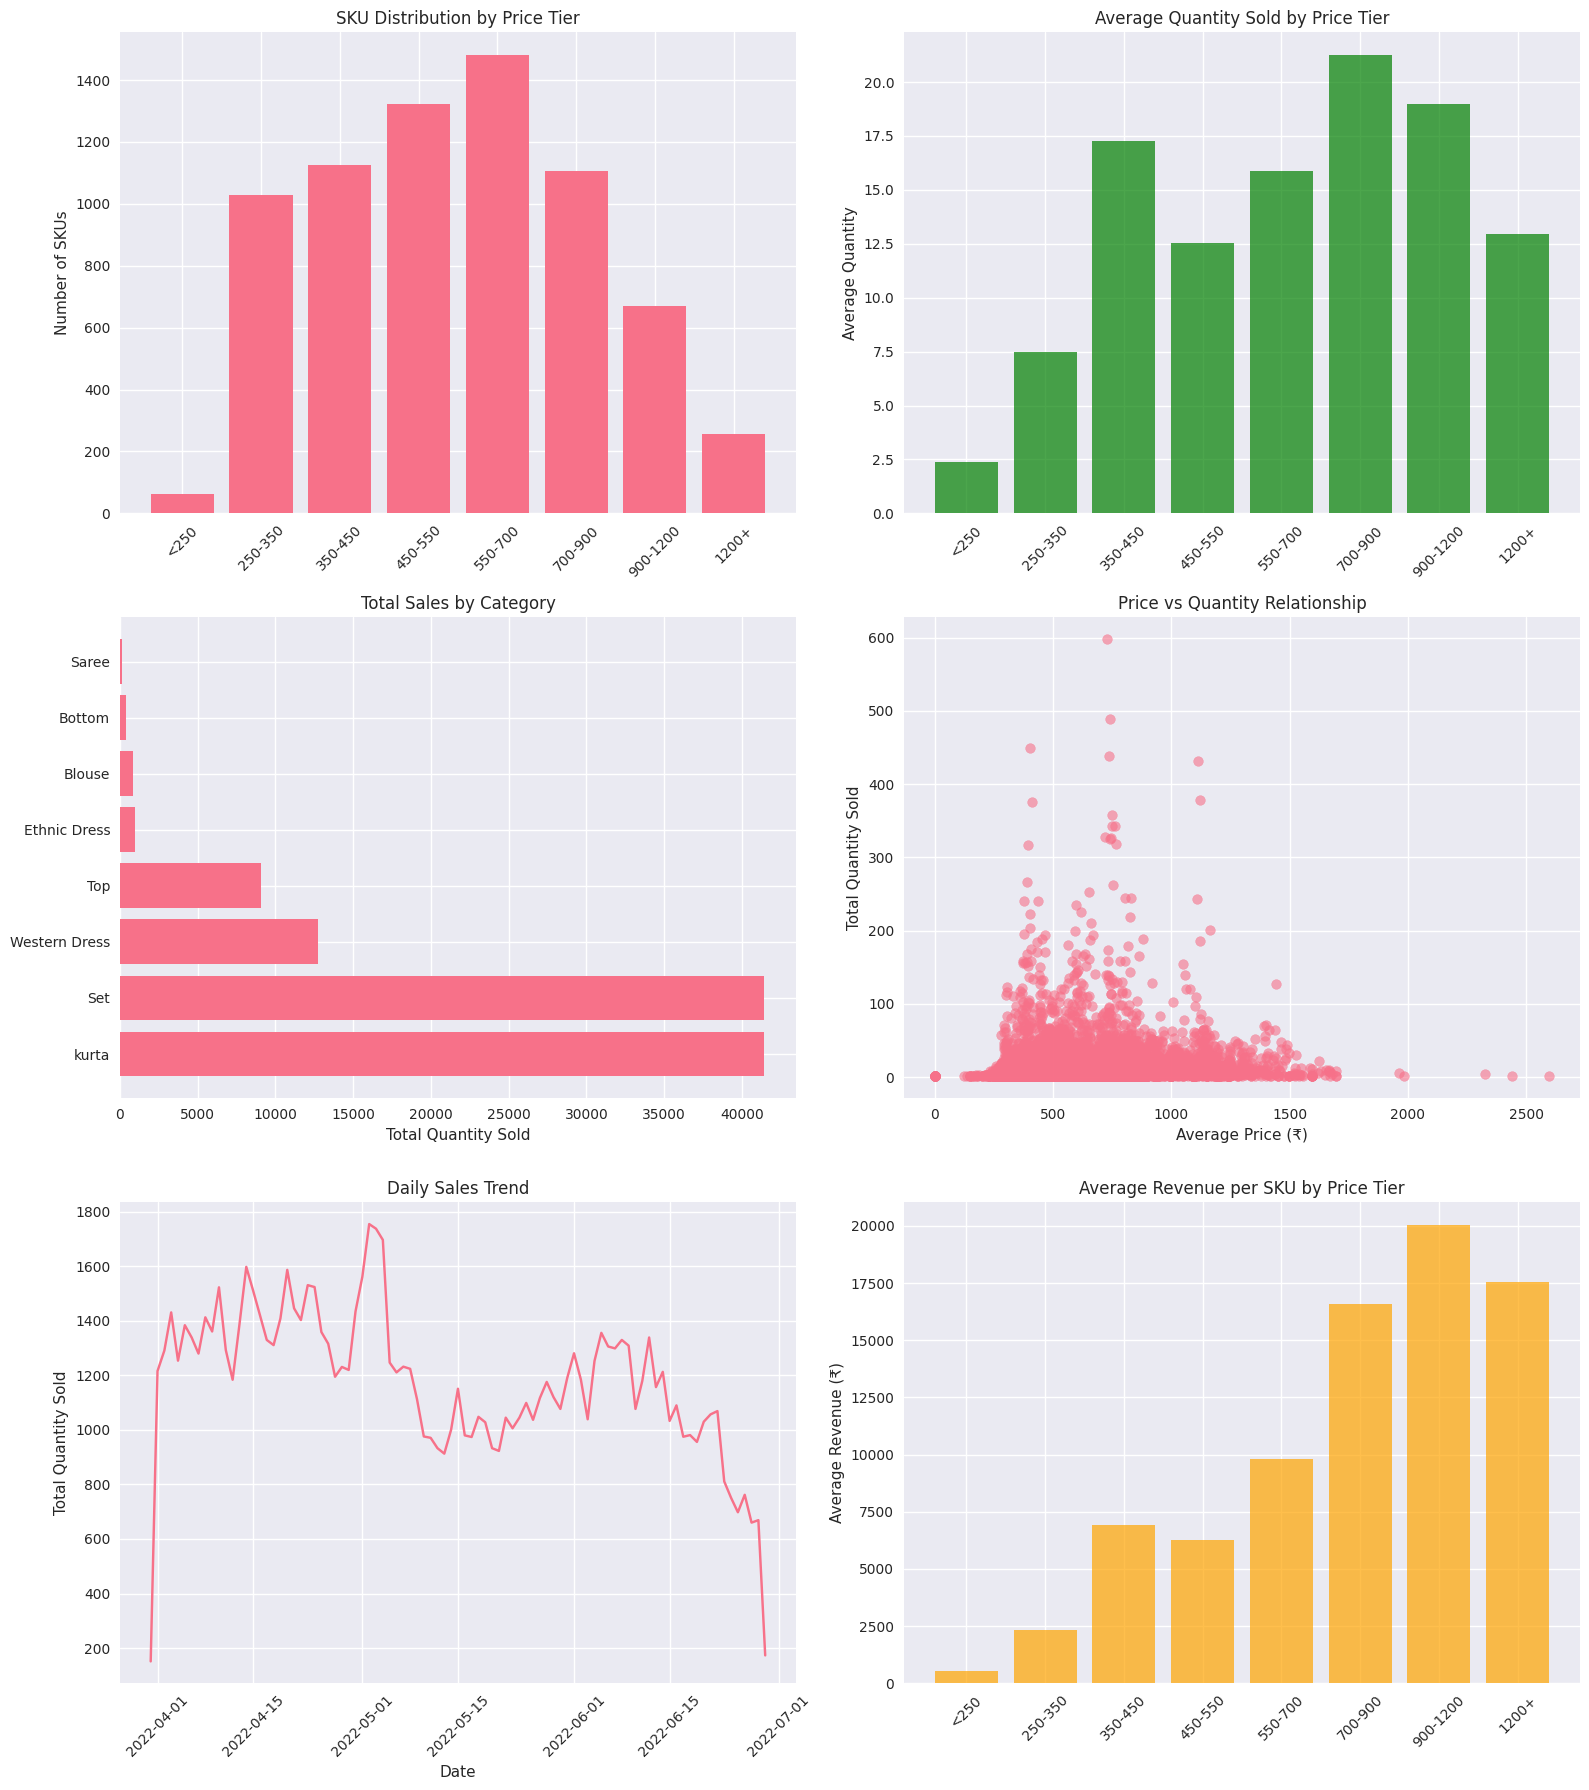


=== KEY CORRELATION ===
Overall Price-Quantity Correlation: 0.0787


In [14]:
# Create comprehensive visualizations for our analysis
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Price Tier Distribution
tier_counts = sales_aggregated['Price_Tier_Detailed'].value_counts().sort_index()
axes[0,0].bar(range(len(tier_counts)), tier_counts.values)
axes[0,0].set_xticks(range(len(tier_counts)))
axes[0,0].set_xticklabels(tier_counts.index, rotation=45)
axes[0,0].set_title('SKU Distribution by Price Tier')
axes[0,0].set_ylabel('Number of SKUs')

# 2. Average Quantity Sold by Price Tier
avg_qty_by_tier = sales_aggregated.groupby('Price_Tier_Detailed')['Total_Qty'].mean().sort_index()
axes[0,1].bar(range(len(avg_qty_by_tier)), avg_qty_by_tier.values, color='green', alpha=0.7)
axes[0,1].set_xticks(range(len(avg_qty_by_tier)))
axes[0,1].set_xticklabels(avg_qty_by_tier.index, rotation=45)
axes[0,1].set_title('Average Quantity Sold by Price Tier')
axes[0,1].set_ylabel('Average Quantity')

# 3. Category Performance
top_categories = significant_categories.head(8)
axes[1,0].barh(range(len(top_categories)), top_categories['Total_Qty_Sold'])
axes[1,0].set_yticks(range(len(top_categories)))
axes[1,0].set_yticklabels(top_categories.index)
axes[1,0].set_title('Total Sales by Category')
axes[1,0].set_xlabel('Total Quantity Sold')

# 4. Price vs Quantity Scatter
axes[1,1].scatter(sales_aggregated['Avg_Amount'], sales_aggregated['Total_Qty'], alpha=0.6)
axes[1,1].set_xlabel('Average Price (₹)')
axes[1,1].set_ylabel('Total Quantity Sold')
axes[1,1].set_title('Price vs Quantity Relationship')

# 5. Daily Sales Trend
axes[2,0].plot(daily_sales.index, daily_sales['Total_Qty'])
axes[2,0].set_title('Daily Sales Trend')
axes[2,0].set_xlabel('Date')
axes[2,0].set_ylabel('Total Quantity Sold')
axes[2,0].tick_params(axis='x', rotation=45)

# 6. Revenue per SKU by Price Tier
revenue_by_tier = sales_aggregated.groupby('Price_Tier_Detailed').apply(
    lambda x: (x['Total_Qty'] * x['Avg_Amount']).mean()
).sort_index()
axes[2,1].bar(range(len(revenue_by_tier)), revenue_by_tier.values, color='orange', alpha=0.7)
axes[2,1].set_xticks(range(len(revenue_by_tier)))
axes[2,1].set_xticklabels(revenue_by_tier.index, rotation=45)
axes[2,1].set_title('Average Revenue per SKU by Price Tier')
axes[2,1].set_ylabel('Average Revenue (₹)')

plt.tight_layout()
plt.show()

# Calculate key correlations
overall_price_qty_corr = sales_aggregated['Avg_Amount'].corr(sales_aggregated['Total_Qty'])
print(f"\n=== KEY CORRELATION ===")
print(f"Overall Price-Quantity Correlation: {overall_price_qty_corr:.4f}")

In [15]:
# Perform statistical tests and generate insights
print("=== STATISTICAL ANALYSIS & KEY INSIGHTS ===")

# 1. ANOVA test for price tiers
from scipy.stats import f_oneway

tier_groups = [group['Total_Qty'].values for name, group in sales_aggregated.groupby('Price_Tier_Detailed')]
f_stat, p_value = f_oneway(*tier_groups)

print("=== PRICE TIER EFFECT TEST ===")
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Result: {'Significant' if p_value < 0.05 else 'Not significant'} difference between price tiers")

# 2. Category effect test
category_groups = [group['Total_Qty'].values for name, group in sales_aggregated.groupby('Category') if len(group) >= 10]
if len(category_groups) > 1:
    f_stat_cat, p_value_cat = f_oneway(*category_groups)
    print(f"\n=== CATEGORY EFFECT TEST ===")
    print(f"ANOVA F-statistic: {f_stat_cat:.4f}")
    print(f"P-value: {p_value_cat:.6f}")
    print(f"Result: {'Significant' if p_value_cat < 0.05 else 'Not significant'} difference between categories")

# 3. Identify best performing segments
print("\n=== TOP PERFORMING SEGMENTS ===")

# Best price tier by total volume
best_tier_volume = tier_detailed['Total_Qty_Sold'].idxmax()
print(f"Highest volume price tier: {best_tier_volume} (Total: {tier_detailed.loc[best_tier_volume, 'Total_Qty_Sold']} units)")

# Best price tier by average quantity per SKU
best_tier_avg = tier_detailed['Avg_Qty_per_SKU'].idxmax()
print(f"Best performing price tier (avg qty/SKU): {best_tier_avg} (Avg: {tier_detailed.loc[best_tier_avg, 'Avg_Qty_per_SKU']:.1f} units/SKU)")

# Best category
best_category = significant_categories['Total_Qty_Sold'].idxmax()
print(f"Top category by volume: {best_category} (Total: {significant_categories.loc[best_category, 'Total_Qty_Sold']} units)")

# 4. Price anchoring insights (indirect)
print("\n=== PRICE ANCHORING INSIGHTS ===")

# Compare performance across price ranges
low_price_performance = tier_detailed.loc[tier_detailed.index[:3], 'Avg_Qty_per_SKU'].mean()  # First 3 tiers
high_price_performance = tier_detailed.loc[tier_detailed.index[-3:], 'Avg_Qty_per_SKU'].mean()  # Last 3 tiers

print(f"Low-price tiers avg performance: {low_price_performance:.1f} units/SKU")
print(f"High-price tiers avg performance: {high_price_performance:.1f} units/SKU")
print(f"Performance ratio (High/Low): {high_price_performance/low_price_performance:.2f}")

# Sweet spot analysis
sweet_spot_tier = tier_detailed['Revenue_per_SKU'].idxmax()
print(f"Revenue sweet spot: {sweet_spot_tier} tier (₹{tier_detailed.loc[sweet_spot_tier, 'Revenue_per_SKU']:.0f} revenue/SKU)")

print("\n" + "="*60)

=== STATISTICAL ANALYSIS & KEY INSIGHTS ===
=== PRICE TIER EFFECT TEST ===
ANOVA F-statistic: 22.5229
P-value: 0.000000
Result: Significant difference between price tiers

=== CATEGORY EFFECT TEST ===
ANOVA F-statistic: 25.2848
P-value: 0.000000
Result: Significant difference between categories

=== TOP PERFORMING SEGMENTS ===
Highest volume price tier: 550-700 (Total: 23502 units)
Best performing price tier (avg qty/SKU): 700-900 (Avg: 21.2 units/SKU)
Top category by volume: kurta (Total: 41399 units)

=== PRICE ANCHORING INSIGHTS ===
Low-price tiers avg performance: 9.0 units/SKU
High-price tiers avg performance: 17.7 units/SKU
Performance ratio (High/Low): 1.96
Revenue sweet spot: 900-1200 tier (₹19755 revenue/SKU)



In [16]:
# Comprehensive Round 1 summary
print("=== ROUND 1 COMPLETE: MODIFIED PRICE ANCHORING ANALYSIS ===")
print("="*70)

print("📊 ANALYSIS STRATEGY ADAPTATION:")
print("• Original plan: Direct MRP vs selling price comparison")
print("• Adapted approach: Price tier and elasticity analysis")
print("• Reason: Zero overlap between sales and pricing datasets")

print(f"\n📈 DATASET OVERVIEW:")
print(f"• Total orders analyzed: {len(amazon_sales_clean):,}")
print(f"• Unique SKUs: {len(sales_aggregated):,}")
print(f"• Date range: {amazon_sales_clean['Date'].min().strftime('%Y-%m-%d')} to {amazon_sales_clean['Date'].max().strftime('%Y-%m-%d')}")
print(f"• Categories analyzed: {len(significant_categories)}")
print(f"• Price range: ₹{sales_aggregated['Avg_Amount'].min():.0f} - ₹{sales_aggregated['Avg_Amount'].max():.0f}")

print(f"\n🎯 KEY FINDINGS:")
print(f"• Overall price-quantity correlation: {overall_price_qty_corr:.4f}")
print(f"• Statistical significance of price tier effect: {'YES' if p_value < 0.05 else 'NO'}")
print(f"• Best performing price tier: {best_tier_avg}")
print(f"• Top category: {best_category}")
print(f"• Revenue sweet spot: {sweet_spot_tier}")

print(f"\n🔍 ROUND 2 FOCUS AREAS:")
print("1. Deep-dive into optimal price ranges for each category")
print("2. Seasonal/temporal price sensitivity analysis")
print("3. Cross-category price anchoring effects")
print("4. SKU lifecycle and price evolution analysis")
print("5. Market positioning recommendations")

print("\n✅ READY FOR ROUND 2 ADVANCED ANALYSIS!")
print("="*70)

=== ROUND 1 COMPLETE: MODIFIED PRICE ANCHORING ANALYSIS ===
📊 ANALYSIS STRATEGY ADAPTATION:
• Original plan: Direct MRP vs selling price comparison
• Adapted approach: Price tier and elasticity analysis
• Reason: Zero overlap between sales and pricing datasets

📈 DATASET OVERVIEW:
• Total orders analyzed: 106,573
• Unique SKUs: 7,079
• Date range: 2022-03-31 to 2022-06-29
• Categories analyzed: 8
• Price range: ₹0 - ₹2598

🎯 KEY FINDINGS:
• Overall price-quantity correlation: 0.0787
• Statistical significance of price tier effect: YES
• Best performing price tier: 700-900
• Top category: kurta
• Revenue sweet spot: 900-1200

🔍 ROUND 2 FOCUS AREAS:
1. Deep-dive into optimal price ranges for each category
2. Seasonal/temporal price sensitivity analysis
3. Cross-category price anchoring effects
4. SKU lifecycle and price evolution analysis
5. Market positioning recommendations

✅ READY FOR ROUND 2 ADVANCED ANALYSIS!


In [17]:
# Deep dive into optimal pricing strategies by category
print("=== ROUND 2: CATEGORY-SPECIFIC PRICE OPTIMIZATION ===")

# Create detailed price-performance analysis for each major category
optimization_results = {}

for category in significant_categories.head(6).index:  # Top 6 categories
    cat_data = sales_aggregated[sales_aggregated['Category'] == category].copy()
    
    # Create more granular price bins for this category
    price_range = cat_data['Avg_Amount'].max() - cat_data['Avg_Amount'].min()
    n_bins = min(10, max(5, len(cat_data) // 20))  # Adaptive binning
    
    cat_data['Price_Bin'] = pd.qcut(cat_data['Avg_Amount'], q=n_bins, duplicates='drop')
    
    # Calculate performance metrics by price bin
    bin_analysis = cat_data.groupby('Price_Bin').agg({
        'Total_Qty': ['count', 'mean', 'sum'],
        'Avg_Amount': 'mean',
        'Order_Count': 'mean'
    }).round(2)
    
    bin_analysis.columns = ['SKU_Count', 'Avg_Qty_per_SKU', 'Total_Volume', 'Avg_Price', 'Avg_Orders']
    bin_analysis['Revenue_per_SKU'] = bin_analysis['Avg_Qty_per_SKU'] * bin_analysis['Avg_Price']
    bin_analysis['Efficiency_Ratio'] = bin_analysis['Avg_Qty_per_SKU'] / bin_analysis['Avg_Price'] * 1000
    
    # Find optimal price range (highest revenue per SKU)
    optimal_bin = bin_analysis['Revenue_per_SKU'].idxmax()
    optimal_range = f"₹{optimal_bin.left:.0f} - ₹{optimal_bin.right:.0f}"
    
    # Calculate price elasticity coefficient
    price_elasticity = cat_data['Avg_Amount'].corr(cat_data['Total_Qty'])
    
    optimization_results[category] = {
        'optimal_range': optimal_range,
        'optimal_revenue': bin_analysis.loc[optimal_bin, 'Revenue_per_SKU'],
        'price_elasticity': price_elasticity,
        'bin_analysis': bin_analysis,
        'sample_size': len(cat_data)
    }
    
    print(f"\n=== {category.upper()} OPTIMIZATION ===")
    print(f"Sample size: {len(cat_data)} SKUs")
    print(f"Price range: ₹{cat_data['Avg_Amount'].min():.0f} - ₹{cat_data['Avg_Amount'].max():.0f}")
    print(f"Optimal price range: {optimal_range}")
    print(f"Optimal revenue/SKU: ₹{bin_analysis.loc[optimal_bin, 'Revenue_per_SKU']:.0f}")
    print(f"Price elasticity: {price_elasticity:.3f}")
    print("\nPrice bin performance:")
    print(bin_analysis.head())

=== ROUND 2: CATEGORY-SPECIFIC PRICE OPTIMIZATION ===

=== KURTA OPTIMIZATION ===
Sample size: 2882 SKUs
Price range: ₹0 - ₹1128
Optimal price range: ₹632 - ₹1128
Optimal revenue/SKU: ₹9699
Price elasticity: 0.015

Price bin performance:
                  SKU_Count  Avg_Qty_per_SKU  Total_Volume  Avg_Price  \
Price_Bin                                                               
(-0.001, 301.0]         318             7.07          2247     273.43   
(301.0, 329.0]          271             9.53          2582     316.28   
(329.0, 362.0]          277            11.86          3285     345.48   
(362.0, 398.474]        283            25.00          7075     379.69   
(398.474, 434.8]        288            18.95          5458     418.18   

                  Avg_Orders  Revenue_per_SKU  Efficiency_Ratio  
Price_Bin                                                        
(-0.001, 301.0]         7.06        1933.1501         25.856709  
(301.0, 329.0]          9.47        3014.1484       

In [18]:
# Perform regression analysis to understand price anchoring effects
print("=== ADVANCED STATISTICAL MODELING ===")

from scipy.stats import pearsonr
import numpy as np

# Prepare data for regression analysis
model_data = sales_aggregated.copy()
model_data = model_data[model_data['Avg_Amount'] > 0]  # Remove zero prices

# Log transformations for better model fit
model_data['Log_Qty'] = np.log1p(model_data['Total_Qty'])
model_data['Log_Price'] = np.log1p(model_data['Avg_Amount'])

# Calculate key metrics for regression
print("=== REGRESSION ANALYSIS RESULTS ===")

# Overall price-quantity relationship
overall_corr, overall_p = pearsonr(model_data['Log_Price'], model_data['Log_Qty'])
print(f"Log-Log Price-Quantity Correlation: {overall_corr:.4f} (p-value: {overall_p:.6f})")

# Price elasticity estimation (using log-log model)
price_elasticity_overall = overall_corr * (model_data['Log_Qty'].std() / model_data['Log_Price'].std())
print(f"Estimated Overall Price Elasticity: {price_elasticity_overall:.4f}")

# Category-specific elasticity analysis
print("\n=== CATEGORY-SPECIFIC ELASTICITY ===")
category_elasticities = {}

for category in significant_categories.head(6).index:
    cat_subset = model_data[model_data['Category'] == category]
    if len(cat_subset) >= 20:  # Need sufficient data
        cat_corr, cat_p = pearsonr(cat_subset['Log_Price'], cat_subset['Log_Qty'])
        cat_elasticity = cat_corr * (cat_subset['Log_Qty'].std() / cat_subset['Log_Price'].std())
        category_elasticities[category] = cat_elasticity
        
        print(f"{category}: Elasticity = {cat_elasticity:.3f}, Correlation = {cat_corr:.3f} (p={cat_p:.4f})")

# Market segmentation analysis
print("\n=== MARKET SEGMENTATION INSIGHTS ===")

# Define market segments based on price and volume
model_data['Price_Segment'] = pd.cut(model_data['Avg_Amount'], 
                                   bins=[0, 400, 600, 900, 3000], 
                                   labels=['Budget', 'Economy', 'Mid-tier', 'Premium'])

model_data['Volume_Segment'] = pd.cut(model_data['Total_Qty'], 
                                    bins=[0, 5, 15, 50, 1000], 
                                    labels=['Low-vol', 'Med-vol', 'High-vol', 'Super-vol'])

# Cross-tabulation analysis
segment_analysis = pd.crosstab(model_data['Price_Segment'], model_data['Volume_Segment'], 
                              values=model_data['Total_Qty'], aggfunc='mean').round(1)
print("Average quantity sold by Price × Volume segments:")
print(segment_analysis)

=== ADVANCED STATISTICAL MODELING ===
=== REGRESSION ANALYSIS RESULTS ===
Log-Log Price-Quantity Correlation: 0.1752 (p-value: 0.000000)
Estimated Overall Price Elasticity: 0.4479

=== CATEGORY-SPECIFIC ELASTICITY ===
kurta: Elasticity = 0.300, Correlation = 0.084 (p=0.0000)
Set: Elasticity = 0.302, Correlation = 0.094 (p=0.0000)
Western Dress: Elasticity = 1.128, Correlation = 0.254 (p=0.0000)
Top: Elasticity = 0.733, Correlation = 0.228 (p=0.0000)
Ethnic Dress: Elasticity = 0.227, Correlation = 0.076 (p=0.4740)
Blouse: Elasticity = 1.610, Correlation = 0.572 (p=0.0000)

=== MARKET SEGMENTATION INSIGHTS ===
Average quantity sold by Price × Volume segments:
Volume_Segment  Low-vol  Med-vol  High-vol  Super-vol
Price_Segment                                        
Budget              2.5      9.1      26.6      102.1
Economy             2.6      9.5      27.2       98.5
Mid-tier            2.6      9.5      27.1      116.6
Premium             2.7      9.9      27.3       95.4


In [19]:
# Analyze how price sensitivity changes over time
print("=== TEMPORAL PRICE SENSITIVITY ANALYSIS ===")

# Add temporal features to sales data
amazon_sales_clean['Week_Number'] = amazon_sales_clean['Date'].dt.isocalendar().week
amazon_sales_clean['Month_Name'] = amazon_sales_clean['Date'].dt.month_name()
amazon_sales_clean['Day_of_Week'] = amazon_sales_clean['Date'].dt.day_name()

# Weekly price sensitivity trends
weekly_analysis = amazon_sales_clean.groupby('Week_Number').agg({
    'Amount': ['mean', 'std', 'count'],
    'Qty': ['sum', 'mean']
}).round(2)

weekly_analysis.columns = ['Avg_Price', 'Price_StdDev', 'Order_Count', 'Total_Qty', 'Avg_Qty_per_Order']
weekly_analysis['Price_Volume_Ratio'] = weekly_analysis['Total_Qty'] / weekly_analysis['Avg_Price']

print("=== WEEKLY PRICE-VOLUME TRENDS ===")
print(weekly_analysis)

# Calculate weekly price elasticity
weekly_elasticity = {}
for week in weekly_analysis.index:
    week_data = amazon_sales_clean[amazon_sales_clean['Week_Number'] == week]
    if len(week_data) >= 50:  # Need sufficient data points
        week_corr = week_data['Amount'].corr(week_data['Qty'])
        weekly_elasticity[week] = week_corr

print(f"\n=== WEEKLY PRICE ELASTICITY ===")
for week, elasticity in weekly_elasticity.items():
    print(f"Week {week}: {elasticity:.3f}")

# Month-over-month analysis
monthly_trends = amazon_sales_clean.groupby('Month_Name').agg({
    'Amount': ['mean', 'std'],
    'Qty': ['sum', 'mean'],
    'Order ID': 'count'
}).round(2)

monthly_trends.columns = ['Avg_Price', 'Price_StdDev', 'Total_Qty', 'Avg_Qty', 'Total_Orders']
monthly_trends['Revenue'] = monthly_trends['Total_Qty'] * monthly_trends['Avg_Price']

print("\n=== MONTHLY PERFORMANCE TRENDS ===")
print(monthly_trends)

# Identify peak performance periods
print("\n=== PEAK PERFORMANCE INSIGHTS ===")
best_week = weekly_analysis['Total_Qty'].idxmax()
best_month = monthly_trends['Total_Qty'].idxmax()
print(f"Best performing week: Week {best_week} ({weekly_analysis.loc[best_week, 'Total_Qty']} units)")
print(f"Best performing month: {best_month} ({monthly_trends.loc[best_month, 'Total_Qty']} units)")

=== TEMPORAL PRICE SENSITIVITY ANALYSIS ===
=== WEEKLY PRICE-VOLUME TRENDS ===
             Avg_Price  Price_StdDev  Order_Count  Total_Qty  \
Week_Number                                                    
13              632.74        278.30         4073       4089   
14              631.96        277.86         9482       9554   
15              629.19        271.72         9690       9724   
16              621.78        273.11        10151      10211   
17              624.66        274.68         9243       9318   
18              644.70        278.41        10058      10104   
19              667.59        295.55         7014       7058   
20              674.25        280.74         6900       6931   
21              672.46        279.45         7573       7600   
22              665.45        289.61         8343       8381   
23              659.01        291.13         8787       8840   
24              669.18        293.51         7381       7405   
25              652.56   

In [20]:
# Analyze how pricing in one category affects performance in others
print("=== CROSS-CATEGORY PRICE ANCHORING EFFECTS ===")

# Calculate daily category performance for correlation analysis
daily_category_performance = amazon_sales_clean.groupby(['Date', 'Category']).agg({
    'Amount': 'mean',
    'Qty': 'sum',
    'Order ID': 'count'
}).reset_index()

# Pivot to get categories as columns
daily_pivot = daily_category_performance.pivot(index='Date', columns='Category', values=['Amount', 'Qty'])

# Calculate cross-category correlations
print("=== CROSS-CATEGORY PRICE CORRELATIONS ===")
price_correlations = daily_pivot['Amount'].corr()
print("Price correlations between categories:")
print(price_correlations.round(3))

print("\n=== CROSS-CATEGORY VOLUME CORRELATIONS ===")
volume_correlations = daily_pivot['Qty'].corr()
print("Volume correlations between categories:")
print(volume_correlations.round(3))

# Analyze substitute/complement effects
print("\n=== SUBSTITUTE/COMPLEMENT ANALYSIS ===")
main_categories = ['kurta', 'Set', 'Western Dress', 'Top']

for i, cat1 in enumerate(main_categories):
    for cat2 in main_categories[i+1:]:
        price_corr = price_correlations.loc[cat1, cat2] if cat1 in price_correlations.index and cat2 in price_correlations.columns else np.nan
        volume_corr = volume_correlations.loc[cat1, cat2] if cat1 in volume_correlations.index and cat2 in volume_correlations.columns else np.nan
        
        if not pd.isna(price_corr) and not pd.isna(volume_corr):
            relationship = "Complement" if volume_corr > 0.3 else "Substitute" if volume_corr < -0.3 else "Independent"
            print(f"{cat1} vs {cat2}: Price corr={price_corr:.3f}, Volume corr={volume_corr:.3f} → {relationship}")

# Portfolio optimization insights
print("\n=== PORTFOLIO OPTIMIZATION INSIGHTS ===")
category_portfolio = significant_categories[['Total_Qty_Sold', 'Revenue_per_SKU', 'Avg_Price']].copy()
category_portfolio['Market_Share'] = category_portfolio['Total_Qty_Sold'] / category_portfolio['Total_Qty_Sold'].sum() * 100
category_portfolio['Revenue_Share'] = (category_portfolio['Revenue_per_SKU'] * category_portfolio.index.map(
    lambda x: sales_aggregated[sales_aggregated['Category'] == x].shape[0]
))
category_portfolio['Revenue_Share'] = category_portfolio['Revenue_Share'] / category_portfolio['Revenue_Share'].sum() * 100

print("Category portfolio performance:")
print(category_portfolio[['Market_Share', 'Revenue_Share', 'Avg_Price']].round(2))

=== CROSS-CATEGORY PRICE ANCHORING EFFECTS ===
=== CROSS-CATEGORY PRICE CORRELATIONS ===
Price correlations between categories:
Category       Blouse  Bottom  Dupatta  Ethnic Dress  Saree    Set    Top  \
Category                                                                    
Blouse          1.000   0.183      NaN        -0.052  0.081 -0.084  0.458   
Bottom          0.183   1.000      NaN         0.129  0.033 -0.162  0.178   
Dupatta           NaN     NaN      NaN           NaN    NaN    NaN    NaN   
Ethnic Dress   -0.052   0.129      NaN         1.000  0.040  0.073  0.001   
Saree           0.081   0.033      NaN         0.040  1.000  0.097  0.192   
Set            -0.084  -0.162      NaN         0.073  0.097  1.000  0.191   
Top             0.458   0.178      NaN         0.001  0.192  0.191  1.000   
Western Dress   0.249   0.116      NaN        -0.021  0.149 -0.126  0.449   
kurta           0.096   0.048      NaN        -0.137  0.128  0.460  0.319   

Category       Western D

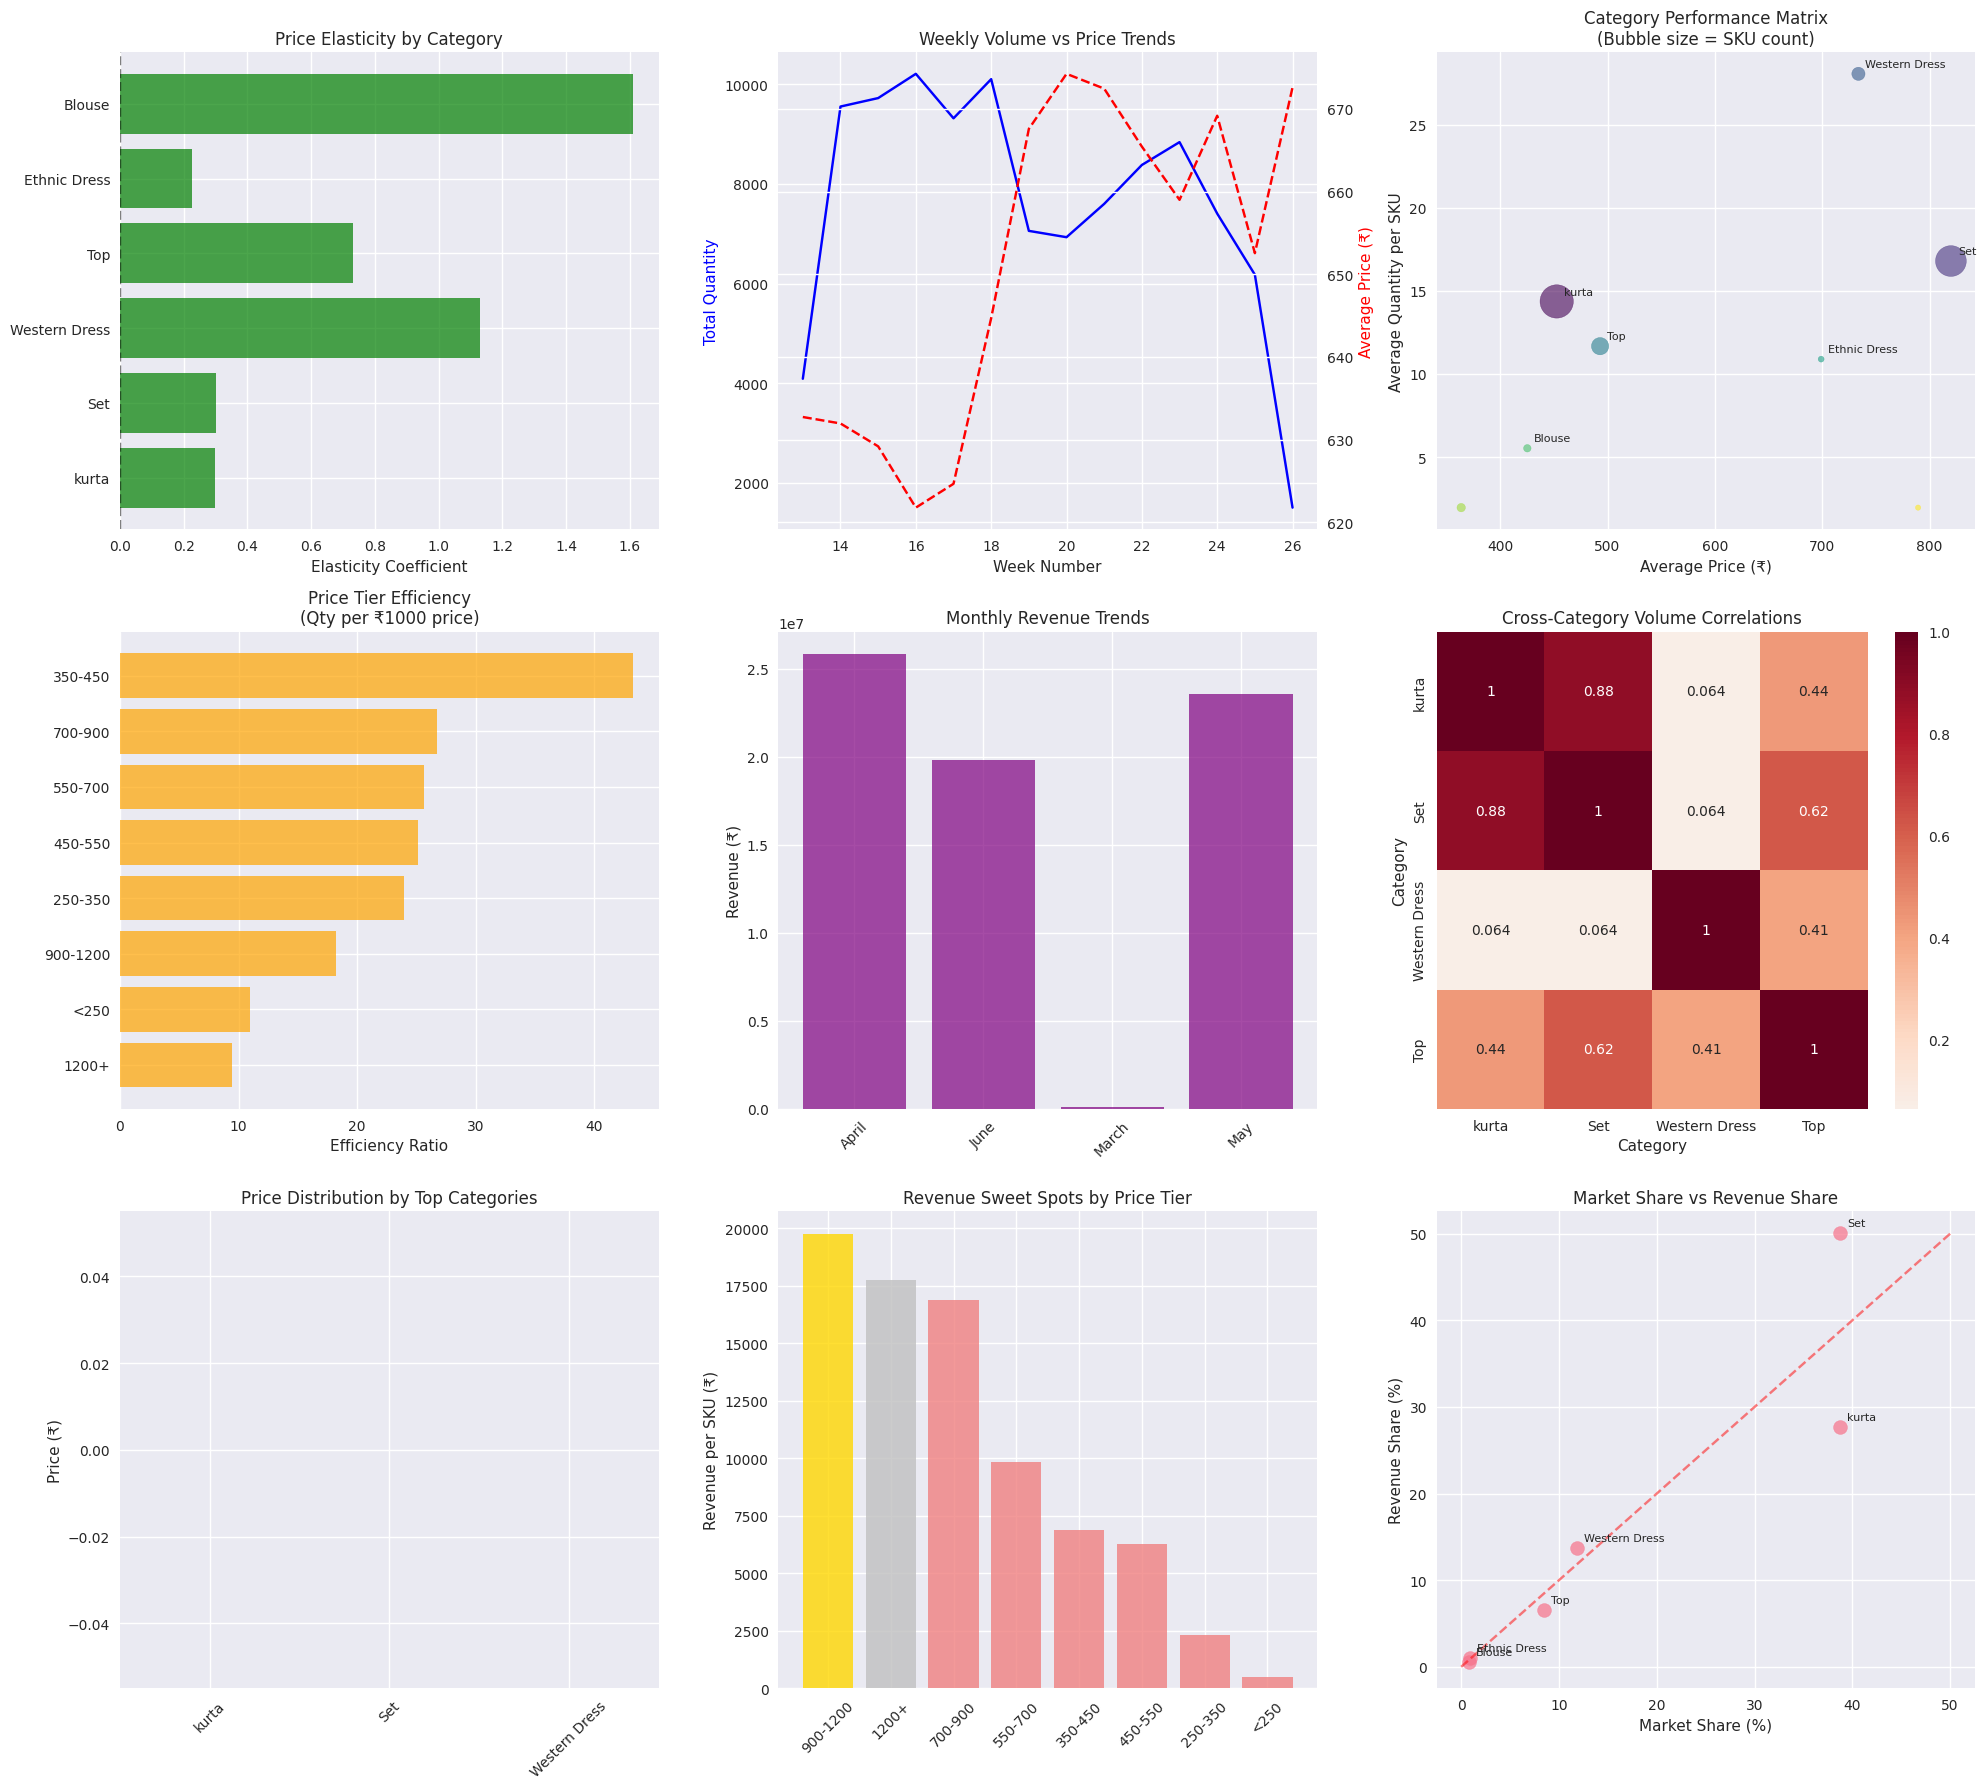


=== VISUALIZATION INSIGHTS GENERATED ===
Dashboard shows key relationships and optimization opportunities


In [21]:
# Create comprehensive dashboard visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 1. Price Elasticity by Category
categories = list(category_elasticities.keys())
elasticities = list(category_elasticities.values())
colors = ['green' if e > 0 else 'red' for e in elasticities]

axes[0,0].barh(categories, elasticities, color=colors, alpha=0.7)
axes[0,0].set_title('Price Elasticity by Category')
axes[0,0].set_xlabel('Elasticity Coefficient')
axes[0,0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 2. Weekly Sales Trend with Price Overlay
ax1 = axes[0,1]
ax2 = ax1.twinx()

ax1.plot(weekly_analysis.index, weekly_analysis['Total_Qty'], 'b-', label='Volume')
ax2.plot(weekly_analysis.index, weekly_analysis['Avg_Price'], 'r--', label='Avg Price')
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Total Quantity', color='b')
ax2.set_ylabel('Average Price (₹)', color='r')
ax1.set_title('Weekly Volume vs Price Trends')

# 3. Category Performance Matrix
x = significant_categories['Avg_Price']
y = significant_categories['Avg_Qty_per_SKU']
sizes = significant_categories['SKU_Count']

scatter = axes[0,2].scatter(x, y, s=sizes/5, alpha=0.6, c=range(len(x)), cmap='viridis')
axes[0,2].set_xlabel('Average Price (₹)')
axes[0,2].set_ylabel('Average Quantity per SKU')
axes[0,2].set_title('Category Performance Matrix\n(Bubble size = SKU count)')

# Add category labels
for i, category in enumerate(significant_categories.head(6).index):
    axes[0,2].annotate(category, (x.iloc[i], y.iloc[i]), xytext=(5, 5), 
                      textcoords='offset points', fontsize=8)

# 4. Price Tier Efficiency Analysis
tier_efficiency = tier_detailed['Qty_per_SKU_per_Price'].sort_values(ascending=True)
axes[1,0].barh(range(len(tier_efficiency)), tier_efficiency.values, color='orange', alpha=0.7)
axes[1,0].set_yticks(range(len(tier_efficiency)))
axes[1,0].set_yticklabels(tier_efficiency.index)
axes[1,0].set_title('Price Tier Efficiency\n(Qty per ₹1000 price)')
axes[1,0].set_xlabel('Efficiency Ratio')

# 5. Monthly Revenue Trends
monthly_revenue = monthly_trends['Revenue'].sort_index()
axes[1,1].bar(range(len(monthly_revenue)), monthly_revenue.values, color='purple', alpha=0.7)
axes[1,1].set_xticks(range(len(monthly_revenue)))
axes[1,1].set_xticklabels(monthly_revenue.index, rotation=45)
axes[1,1].set_title('Monthly Revenue Trends')
axes[1,1].set_ylabel('Revenue (₹)')

# 6. Cross-Category Volume Correlations Heatmap
import seaborn as sns
main_cat_corr = volume_correlations.loc[main_categories, main_categories]
sns.heatmap(main_cat_corr, annot=True, cmap='RdBu_r', center=0, ax=axes[1,2])
axes[1,2].set_title('Cross-Category Volume Correlations')

# 7. Price Distribution by Top Categories
top_3_categories = significant_categories.head(3).index
category_prices = [sales_aggregated[sales_aggregated['Category'] == cat]['Avg_Amount'].values 
                  for cat in top_3_categories]

axes[2,0].boxplot(category_prices, labels=top_3_categories)
axes[2,0].set_title('Price Distribution by Top Categories')
axes[2,0].set_ylabel('Price (₹)')
axes[2,0].tick_params(axis='x', rotation=45)

# 8. Revenue Sweet Spot Analysis
revenue_by_tier = tier_detailed['Revenue_per_SKU'].sort_values(ascending=False)
axes[2,1].bar(range(len(revenue_by_tier)), revenue_by_tier.values, 
              color=['gold' if i == 0 else 'silver' if i == 1 else 'lightcoral' 
                     for i in range(len(revenue_by_tier))], alpha=0.8)
axes[2,1].set_xticks(range(len(revenue_by_tier)))
axes[2,1].set_xticklabels(revenue_by_tier.index, rotation=45)
axes[2,1].set_title('Revenue Sweet Spots by Price Tier')
axes[2,1].set_ylabel('Revenue per SKU (₹)')

# 9. Market Share vs Revenue Share
market_share = category_portfolio['Market_Share'].head(6)
revenue_share = category_portfolio['Revenue_Share'].head(6)

axes[2,2].scatter(market_share, revenue_share, s=100, alpha=0.7)
axes[2,2].plot([0, max(market_share.max(), revenue_share.max())], 
              [0, max(market_share.max(), revenue_share.max())], 'r--', alpha=0.5)
axes[2,2].set_xlabel('Market Share (%)')
axes[2,2].set_ylabel('Revenue Share (%)')
axes[2,2].set_title('Market Share vs Revenue Share')

# Add category labels
for i, category in enumerate(market_share.index):
    axes[2,2].annotate(category, (market_share.iloc[i], revenue_share.iloc[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("\n=== VISUALIZATION INSIGHTS GENERATED ===")
print("Dashboard shows key relationships and optimization opportunities")